# Т-1

## Случайный вектор $(\xi_1, \xi_2, \xi_3, \xi_4, \xi_5, \eta)$ имеет компоненты, распределенные по следующему закону: $\xi_k \sim R(-1,1)$, $\eta \sim N(2 + 3x_1 - 2x_2 + x_3 + x_4 - x_5, 1.5^2)$, где $x_k$ это значения, которые принимает случайная величина $\xi_k$. Сгенерировать выборку объема $(n = 50)

In [1251]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from scipy import stats
from scipy.stats import t
from scipy.stats import f
from scipy.stats import rankdata, norm
from statsmodels.stats.diagnostic import lilliefors
import matplotlib.pyplot as plt

In [1252]:
# Генерация выборки
np.random.seed(19)
n = 50
sigma = 1.5
p = 6
df = n - 6

# Генерация xi_k ~ R(-1, 1)
xi = np.random.uniform(-1, 1, size = (n, 5))
xi1 = xi[:, 0] 
xi2 = xi[:, 1]
xi3 = xi[:, 2]
xi4 = xi[:, 3]
xi5 = xi[:, 4]

# Генерация eta ~ N(2 + 3x1 - 2x2 + x3 + x4 - x5, 1.5^2)
betas = np.array([2, 3, -2, 1, 1, -1])
psi = np.column_stack([np.ones(n), xi]) # Наша матрица пси_большое
eta_mean = 2 + 3*xi1 - 2*xi2 + xi3 + xi4 - xi5
eta = np.random.normal(eta_mean, sigma, n)

data = pd.DataFrame(xi, columns=[f'xi_{k+1}' for k in range(5)])
data['eta'] = eta
data = data.round(3)


### a) Проверить переменные \($\xi_k$\) на мультиколлинеарность.

In [1253]:
#a) Проверка на мультиколлинеарность
def rss(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2)

def tss(y_true):
    return np.sum((y_true - np.mean(y_true)) ** 2)

def r_squared(y_true, y_pred):
    return np.abs(1 - (rss(y_true, y_pred) / tss(y_true)))

X = data[["xi_1", "xi_2", "xi_3", "xi_4", "xi_5"]]

for k in range(1, 6):
    target = X[f"xi_{k}"]
    features = X.drop(f"xi_{k}", axis=1)    
   
    features_with_const = sm.add_constant(features) #добавляем столбец единиц
    
    # Строим регрессию
    model = sm.OLS(target, features_with_const).fit()
    
    print(f"R² для xi_{k} на остальные переменные: {model.rsquared:.3f}")

R² для xi_1 на остальные переменные: 0.053
R² для xi_2 на остальные переменные: 0.027
R² для xi_3 на остальные переменные: 0.055
R² для xi_4 на остальные переменные: 0.058
R² для xi_5 на остальные переменные: 0.049


### b) Определить уравнение линейной регрессии: $\eta = \beta_0 + \sum_{k=1}^5 \beta_k \xi_k$ и проверить значимость коэффициентов.

In [1254]:
PSI = sm.add_constant(X)

# Регрессия η
model = sm.OLS(data['eta'], PSI).fit()
print(f"Params:\n{model.params}\n")

F = PSI.T @ PSI
F_inv = np.linalg.inv(F) #Получили матрицу Фишера

RSS = model.ssr
print(f'RSS: {RSS}')

# Проверка значимости коэфф. регрессии
labels = ['xi_1', 'xi_2', 'xi_3', 'xi_4', 'xi_5']

pValues_list = list()

sign_df = pd.DataFrame(columns = ["Параметр", "Дельта", "P-value", "Итог"])
for k in range(len(labels)):
    delta = model.params[labels[k]] * np.sqrt(df) / np.sqrt(RSS * F_inv[k][k])
    p_value = 2 * t.cdf(-np.abs(delta), df)
    pValues_list.append(p_value)    
    

pValues = np.array(pValues_list)
print(f"p-values для коэффициентов: {pValues}")
for i in range(1,len(pValues)+1):
    if(pValues[i-1] < 0.05):
        print(f"параметр xi_{i} значим")
        continue    
    print(f"параметр xi_{i}  не значим")


Params:
const    2.189488
xi_1     3.151650
xi_2    -1.305915
xi_3     1.059006
xi_4     1.303048
xi_5    -0.497267
dtype: float64

RSS: 81.24833708302756
p-values для коэффициентов: [4.57151312e-19 8.57728238e-04 3.99803199e-03 4.22413574e-04
 1.24843326e-01]
параметр xi_1 значим
параметр xi_2 значим
параметр xi_3 значим
параметр xi_4 значим
параметр xi_5  не значим


### c) Определить коэффициент детерминации и проверить его значимость.

$$
\Delta \sim F(5, 44)
$$

In [1255]:
#c) Определить коэффициент детерминации и проверить его значимость

print(f'Коэффициент детерминации: {model.rsquared}')

TSS = model.centered_tss

delta = (TSS - RSS) * (df) / (RSS * (n - df - 1))
p_value = f.sf(delta, n - df - 1, df)
print(f'TSS: {TSS}')
print(f'RSS: {RSS}')
print(f'delta: {delta:.4f}')  
print(f'p-value: {p_value}')
if(p_value < 0.05):
    print("Регрессия значима")
else:
    print("Регрессия не значима")

Коэффициент детерминации: 0.7300629466621604
TSS: 300.98993850000005
RSS: 81.24833708302756
delta: 23.8002
p-value: 1.656446455631446e-11
Регрессия значима


### d) Найти значение в точке \($x_k$ = 0\) и построить 95% доверительный интервал.

In [1256]:
y_tilda = model.params['const']

print(y_tilda)

X_0 = np.array([1, 0, 0, 0, 0, 0])

delta = t.ppf(1 - 0.05/2, df) * np.sqrt(1 + X_0 @ F_inv @ X_0.T) * np.sqrt(RSS/df)

print(f'Доверительный интервал: ({round(y_tilda - delta, 4)}, {round(y_tilda + delta, 4)})')


2.189487843151286
Доверительный интервал: (-0.5811, 4.9601)


### e) Проверить предположение о независимости ошибок измерения.

$H_0$: Ошибки измерения независимы и одинаковы распределены

$H_1: \overline H_0$

In [1257]:
e = model.resid

def count_inversions(arr):
    ranks = rankdata(arr, method='average')  # Преобразуем в ранги
    inv_count = 0
    for i in range(len(ranks)):
        inv_count += np.sum(ranks[i+1:] < ranks[i])  # Считаем инверсии
    return int(inv_count)

delta = (count_inversions(e) - n * (n - 1) / 4) / np.sqrt((n ** 3) / 36)
p_value = 2*norm.sf(np.abs(delta), 0, 1)
print(f'Дельта: {delta}')  
print(f'P-value: {p_value}')

if(p_value < 0.05):
    print("Отвергаем H0")
else:
    print("Нет оснований отвергнуть H0")


Дельта: 0.6363961030678927
P-value: 0.5245182802130763
Нет оснований отвергнуть H0



### f) Проверить предположение о нормальности распределения ошибок.

$H_0$: Ошибки измерения нормально распределены $$ e_i \sim \mathcal{N}(0, \sigma^2) $$


$H_1: \overline H_0$

In [1258]:
delta, p_value = lilliefors(e)
print(f'Дельта: {delta}')
print(f'P-value: {p_value}')

if(p_value < 0.05):
    print("Отвергаем H0")
else:
    print("Нет оснований отвергнуть H0")

Дельта: 0.10979751537403759
P-value: 0.1437212636954675
Нет оснований отвергнуть H0


### g) Исследовать регрессию на выбросы.

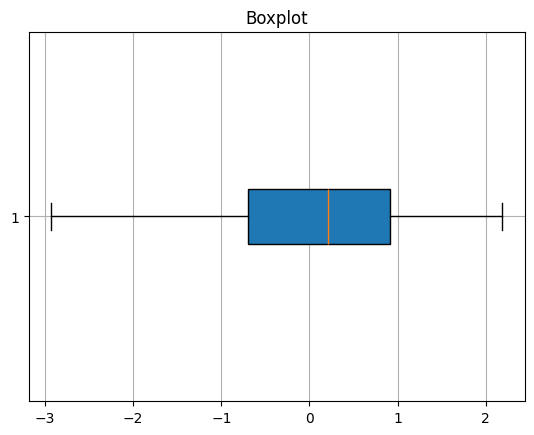

In [1259]:
fig, ax = plt.subplots()
ax.boxplot(e, vert=False, patch_artist=True, showfliers=True)
ax.set_title('Boxplot')
ax.axis('on')
ax.grid()
plt.show()

### h) Провести кросс-проверку регрессии.

In [1260]:
CVSS = 0
for i in range(n):
    train_x = sm.add_constant(data.drop(i))[labels] # матрица признаков без i-того наблюдения
    train_y= sm.add_constant(data.drop(i)).eta # переменная eta без i-того наблюдения

    test_x = (sm.add_constant(data)[labels]).iloc[i] # i-тое наблюдение (признаки + константа).
    test_y = (sm.add_constant(data).eta).iloc[i] #  истинное значение eta для i-того наблюдения

    model_n = sm.OLS(train_y, train_x).fit()
    y_wave = model_n.params.dot(test_x)

    CVSS += (y_wave - test_y) ** 2

print(f'CVSS: {round(CVSS, 3)}')
print(f'R² кросс-валидации: {round(np.abs(model.centered_tss - CVSS) / model.centered_tss, 4)}')

CVSS: 359.361
R² кросс-валидации: 0.1939


### i) Проверить адекватность регрессии, сделав 5 повторных измерений в одной точке.

$$
\tilde{\sigma}_1^2 = \frac{\sum_{i=1}^{n}{(y_i - \overline y)^2}}{l - 1}
$$

$$
\Delta \sim F(n - p, l - 1)
$$

In [1261]:
point = [1, 0, 0, 0, 0, 0]
N = 5
eta_one_point = np.random.normal(2, 1.5, N)

y_mean = np.mean(eta_one_point)
sigma_tilda = np.sum((eta_one_point - y_mean) ** 2) / (N - 1)

delta = round(RSS / (df * sigma_tilda), 4)
p_value = round(f.sf(delta, df, N - 1), 4)
print(f'Дельта: {delta}')
print(f'p-value: {p_value}')
if(p_value > 0.05):
    print("Модель адекватна")
else:
    print("Модель не адекватна")


Дельта: 0.7935
p-value: 0.7
Модель адекватна


### j) Удалить переменную, соответствующую наименее значимому коэфициенту и повторить пункты b и с, сравнить уравнения регрессии.

In [1262]:
# xi_5 наименее значимый, т. к. самый маленький коэффициент
X_dim = data[['xi_1', 'xi_2', 'xi_3', 'xi_4']]
k = -1

PSI_dim = sm.add_constant(X_dim)

model_dim = sm.OLS(data['eta'], PSI_dim).fit()
print(f"Params:\n{model_dim.params}\n")

F_dim = PSI_dim.T @ PSI_dim
F_inv_dim = np.linalg.inv(F_dim)

RSS_dim = model_dim.ssr
print(f'RSS: {RSS_dim:.4f}\n')

labels_dim = ['const', 'xi_1', 'xi_2', 'xi_3', 'xi_4']

sign_df = pd.DataFrame(columns = ["Параметр", "Дельта", "P-value", "Итог"])
for k in range(0, len(labels_dim)):
    delta = model_dim.params[labels_dim[k]] * np.sqrt(model_dim.df_resid) / np.sqrt(RSS_dim * F_inv_dim[k][k])
    p_value = 2 * t.cdf(-np.abs(delta), model_dim.df_resid)
    if (p_value < 0.05):
        sign_df.loc[k] = [labels[k], delta, p_value, 'Параметр значим']
    else:
        sign_df.loc[k] = [labels[k], delta, p_value, 'Параметр незначим']

print(sign_df)

Params:
const    2.167960
xi_1     3.155124
xi_2    -1.260944
xi_3     1.003794
xi_4     1.230672
dtype: float64

RSS: 85.3513

  Параметр     Дельта       P-value             Итог
0     xi_1  10.305077  2.011490e-13  Параметр значим
1     xi_2   8.529394  5.923143e-11  Параметр значим
2     xi_3  -3.582445  8.317793e-04  Параметр значим
3     xi_4   2.916327  5.506159e-03  Параметр значим
4     xi_5   3.866017  3.529624e-04  Параметр значим


### k. Сравнить уравнения регрессии бутстрапом.

In [1263]:
# Количество повторений бутстрапа
n_iterations = 1000
beta = 0.95

# Оценка полученная ОМП
h_wave = model.rsquared - model_dim.rsquared
bootstrap_delta = []

for _ in range(n_iterations):
    sample = sm.add_constant(data.sample(n=n, replace=True))
    b_model = sm.OLS(sample.eta, sample[labels]).fit()
    b_model_dim = sm.OLS(sample.eta, sample[labels_dim]).fit()
    bootstrap_delta.append(b_model.rsquared - b_model_dim.rsquared - h_wave)

variation_row = sorted(bootstrap_delta)

t = variation_row[int((1 - beta) * n_iterations)]

lower_bound = (h_wave - variation_row[-1])*k
upper_bound = h_wave - t

print(f'Доверительный интервал: ({lower_bound}, {upper_bound}), длина: {upper_bound - lower_bound}')
if (lower_bound * upper_bound > 0):
    print('Различие значимо')
else:
    print('Различие незначимо')

Доверительный интервал: (0.23274284046444604, 0.4719827078905581), длина: 0.23923986742611203
Различие значимо
